# Introduction

Github Link : https://github.com/kgulati2/DL4H_Draft

Video Link: https://github.com/kgulati2/DL4H_Draft/blob/main/CS598VideoDL4H.mp4

Electronic health records (EHRs) are a digital version of a patient's medical history. They can capture patient encounters and include structured examples such as lab results and medication information as well as unstructured examples such as clinical notes and medical imaging. The modeling of these EHRs is becoming an important topic in both academia as well as industry. Researchers have used the model architecture MiME to reflect an EHR's encounter structure particularly in mapping the relationship between a diagnosis and treatment. They found it outperformed the alternative bag of features approach in prediction tasks like heart failure diagnosis prediction [Choi et al. 2018]. The problem is that not all EHR data contains structured information detailing the relationships between different features. Taking this even further |  claims data generally has no structured information available at all. The underlying question is whether it is possible to outperform the bag of features approach in representing data for prediction tasks.

The paper proposed the approach of using the Graph Convolutional Transformer (GCT) |  which is a novel approach that can learn the hidden structure of EHRs while performing prediction tasks [Choi et al. 2020]. It represents EHR data as a graph where the nodes represent medical entities and the edges denote specific relationships between the entities. The GCT model combines graph convolutional networks (GCNs) innovating with the incorporation of a self-attention mechanism as well as the transformer architecture. This enables it to learn embeddings and relationships between EHR entities. Those embeddings can then be used for predictive tasks such as heart failure diagnosis prediction. The proposed method worked extremely well and researchers found that GCT outperforms baseline models in all prediction tasks including graph reconstruction and readmission prediction with both synthetic data as well as a publicly available HER dataset. This shows the potential GCT has in serving as an effective general purpose representation learning algorithm for EHR data. This paper is incredibly important to the research regime of modeling EHR data because it introduced a pioneering approach for analyzing EHRs using graph representation and the GCT model. This method significantly enhances predictive accuracy across various healthcare tasks and offers a promising avenue to leverage HER data and improve patient care.

# Scope of Reproducibility

Hypothesis: Learning the hidden structure of EHR data using the Graph Convolution Transformer |  while performing supervised prediction tasks on EHR data will empirically outperform previous approaches (such as bag of features).

Experiment: The testing of this hypothesis involves comparing the performance of the Graph Convolutional Transformer (GCT) model against previous approaches like the bag of features method in supervised prediction tasks that use EHR data. The experiment includes preprocessing the EHR data to represent it as graphs for the GCT model and feature vectors for the bag of features method. The models will then be trained and their performance metrics will be evaluated against one another. By comparing the predictive performance of the GCT model against the bag of features method |  the experiment aims to empirically demonstrate whether leveraging the hidden structure of EHR data with the GCT model leads to superior predictive performance compared to traditional approaches.

# Methodology

### Environment

The version used for this code is Python 2.7. We realize this is an outdated version of python, but the reason we decided to use this was because the original code was coded in Python 2.7. Rather than to try and find all the right packages and dependencies and update all the code, we decided it would be easier to configure our environment to fit the needs of the code.

You will need to create a virtual environment. Create a virtual environment using virtualenv and name it venv_gnn using terminal. Then you will open up the virtual environment and install the right python version, tensorflow, and scikit-learn.

### Data

Source of the data: In order to gain access to the EHR data you first need to request access to the eICU dataset from the eICU website (https://eicu-crd.mit.edu/gettingstarted/access/). This requires some CITI training as this data is restricted non-public data.

In order to gain access, there are a couple of additional steps:

1. Register with the CITI program website (https://www.citiprogram.org/index.cfm?pageID=154&icat=0&ac=0) and select “Massachusetts Institute of Technology Affiliates” as the affiliation
![Screen Shot 2024-04-29 at 8.17.19 PM.png](<attachment:Screen Shot 2024-04-29 at 8.17.19 PM.png>)
2. Follow the links, add the MIT course. In the training category, select “Data or Specimens Only Research”
3. Once you complete the course, be sure to save a copy of the completion.

Now that you have done this, you can proceed to request access to the data:
1. Navigate to the PhysioNet website (https://physionet.org/) and create an account / log in.
2. Go to the Project page (https://physionet.org/content/eicu-crd/)
3. Find "Files" section, select "credential user", and submit the application and add your completed CITI report.

Following these steps and a short waiting period, you will gain access to the dataset. You can now download the data!

There are 4 files of data that are taken from this dataset and are as follows:

| admissionDx.csv (626859 Lines)| diagnosis.csv (2710673 Lines)| patient.csv (200860 Lines)| treatment.csv (3688746 Lines)|
| --- | --- | --- | --- |

They contain the following data:

| admissionDx.csv | diagnosis.csv | patient.csv | treatment.csv |
| --- | --- | --- | --- |
| admissiondxid | diagnosisid | patientunitstayid | treatmentid |
| patientunitstayid | patientunitstayid | patienthealthsystemstayid | patientunitstayid |
| admitdxenteredoffset | activeupondischarge | gender | treatmentoffset |
| admitdxpath | diagnosisoffset | age | treatmentstring |
| admitdxname | diagnosisstring | hospitalid | activeupondischarge |
| admitdxtext | icd9code | wardid |
| | diagnosispriority | apacheadmissiondx |
| | | admissionheight |
| | | hospitaladmittime24 |
| | | hospitaladmitoffset |
| | | hospitaladmitsource |
| | | hospitaldischargeyear |
| | | hospitaldischargetime24 |
| | | hospitaldischargeoffset |
| | | hospitaldischargelocation |
| | | hospitaldischargestatus |
| | | unittype |
| | | unitadmittime24 |
| | | unitadmitsource |
| | | unitvisitnumber |
| | | unitstaytype |
| | | admissionweight |
| | | dischargeweight |
| | | unitdischargetime24 |
| | | unitdischargeoffset |
| | | unitdischargelocation |
| | | unitdischargestatus |
| | | uniquepid |
| | | ethnicity |

In order to make the raw data fit for usage for the purposes of this experiment and generate TFRecords, data preprocessing code was run. This code generated 5 randomly sampled sets of train/validation/test data. This code was provided by the authors of the original paper.


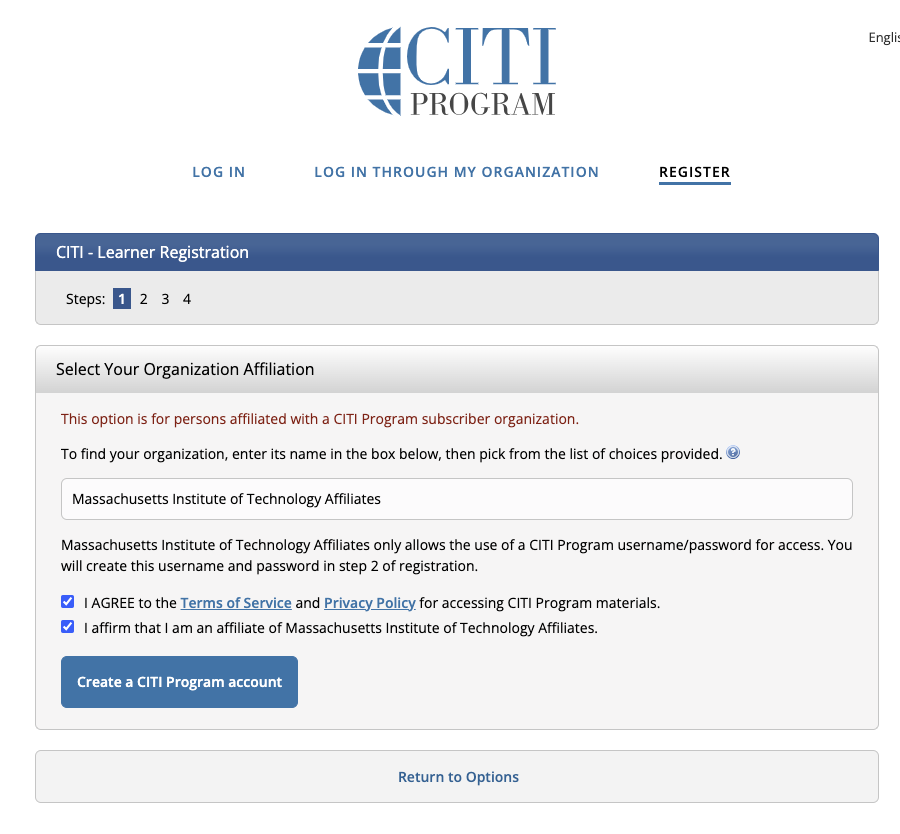

You can then run the following code with the terminal command specifying the paths:

In [ ]:
"""Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

from __future__ import division
from __future__ import print_function

import cPickle as pickle
import csv
import os
import sys
import numpy as np
import sklearn.model_selection as ms
import tensorflow as tf


class EncounterInfo(object):

  def __init__(self, patient_id, encounter_id, encounter_timestamp, expired,
               readmission):
    self.patient_id = patient_id
    self.encounter_id = encounter_id
    self.encounter_timestamp = encounter_timestamp
    self.expired = expired
    self.readmission = readmission
    self.dx_ids = []
    self.rx_ids = []
    self.labs = {}
    self.physicals = []
    self.treatments = []


def process_patient(infile, encounter_dict, hour_threshold=24):
  inff = open(infile, 'r')
  count = 0
  patient_dict = {}
  for line in csv.DictReader(inff):
    if count % 10000 == 0:
      sys.stdout.write('%d\r' % count)
      sys.stdout.flush()

    patient_id = line['patienthealthsystemstayid']
    encounter_id = line['patientunitstayid']
    encounter_timestamp = -int(line['hospitaladmitoffset'])
    if patient_id not in patient_dict:
      patient_dict[patient_id] = []
    patient_dict[patient_id].append((encounter_timestamp, encounter_id))
  inff.close()
  print('')

  patient_dict_sorted = {}
  for patient_id, time_enc_tuples in patient_dict.iteritems():
    patient_dict_sorted[patient_id] = sorted(time_enc_tuples)

  enc_readmission_dict = {}
  for patient_id, time_enc_tuples in patient_dict_sorted.iteritems():
    for time_enc_tuple in time_enc_tuples[:-1]:
      enc_id = time_enc_tuple[1]
      enc_readmission_dict[enc_id] = True
    last_enc_id = time_enc_tuples[-1][1]
    enc_readmission_dict[last_enc_id] = False

  inff = open(infile, 'r')
  count = 0
  for line in csv.DictReader(inff):
    if count % 10000 == 0:
      sys.stdout.write('%d\r' % count)
      sys.stdout.flush()

    patient_id = line['patienthealthsystemstayid']
    encounter_id = line['patientunitstayid']
    encounter_timestamp = -int(line['hospitaladmitoffset'])
    discharge_status = line['unitdischargestatus']
    duration_minute = float(line['unitdischargeoffset'])
    expired = True if discharge_status == 'Expired' else False
    readmission = enc_readmission_dict[encounter_id]

    if duration_minute > 60. * hour_threshold:
      continue

    ei = EncounterInfo(patient_id, encounter_id, encounter_timestamp, expired,
                       readmission)
    if encounter_id in encounter_dict:
      print('Duplicate encounter ID!!')
      sys.exit(0)
    encounter_dict[encounter_id] = ei
    count += 1

  inff.close()
  print('')

  return encounter_dict


def process_admission_dx(infile, encounter_dict):
  inff = open(infile, 'r')
  count = 0
  missing_eid = 0
  for line in csv.DictReader(inff):
    if count % 10000 == 0:
      sys.stdout.write('%d\r' % count)
      sys.stdout.flush()

    encounter_id = line['patientunitstayid']
    dx_id = line['admitdxpath'].lower()

    if encounter_id not in encounter_dict:
      missing_eid += 1
      continue
    encounter_dict[encounter_id].dx_ids.append(dx_id)
    count += 1
  inff.close()
  print('')
  print('Admission Diagnosis without Encounter ID: %d' % missing_eid)

  return encounter_dict


def process_diagnosis(infile, encounter_dict):
  inff = open(infile, 'r')
  count = 0
  missing_eid = 0
  for line in csv.DictReader(inff):
    if count % 10000 == 0:
      sys.stdout.write('%d\r' % count)
      sys.stdout.flush()

    encounter_id = line['patientunitstayid']
    dx_id = line['diagnosisstring'].lower()

    if encounter_id not in encounter_dict:
      missing_eid += 1
      continue
    encounter_dict[encounter_id].dx_ids.append(dx_id)
    count += 1
  inff.close()
  print('')
  print('Diagnosis without Encounter ID: %d' % missing_eid)

  return encounter_dict


def process_treatment(infile, encounter_dict):
  inff = open(infile, 'r')
  count = 0
  missing_eid = 0

  for line in csv.DictReader(inff):
    if count % 10000 == 0:
      sys.stdout.write('%d\r' % count)
      sys.stdout.flush()

    encounter_id = line['patientunitstayid']
    treatment_id = line['treatmentstring'].lower()

    if encounter_id not in encounter_dict:
      missing_eid += 1
      continue
    encounter_dict[encounter_id].treatments.append(treatment_id)
    count += 1
  inff.close()
  print('')
  print('Treatment without Encounter ID: %d' % missing_eid)
  print('Accepted treatments: %d' % count)

  return encounter_dict


def build_seqex(enc_dict,
                skip_duplicate=False,
                min_num_codes=1,
                max_num_codes=50):
  key_list = []
  seqex_list = []
  dx_str2int = {}
  treat_str2int = {}
  num_cut = 0
  num_duplicate = 0
  count = 0
  num_dx_ids = 0
  num_treatments = 0
  num_unique_dx_ids = 0
  num_unique_treatments = 0
  min_dx_cut = 0
  min_treatment_cut = 0
  max_dx_cut = 0
  max_treatment_cut = 0
  num_expired = 0
  num_readmission = 0

  for _, enc in enc_dict.iteritems():
    if skip_duplicate:
      if (len(enc.dx_ids) > len(set(enc.dx_ids)) or
          len(enc.treatments) > len(set(enc.treatments))):
        num_duplicate += 1
        continue

    if len(set(enc.dx_ids)) < min_num_codes:
      min_dx_cut += 1
      continue

    if len(set(enc.treatments)) < min_num_codes:
      min_treatment_cut += 1
      continue

    if len(set(enc.dx_ids)) > max_num_codes:
      max_dx_cut += 1
      continue

    if len(set(enc.treatments)) > max_num_codes:
      max_treatment_cut += 1
      continue

    count += 1
    num_dx_ids += len(enc.dx_ids)
    num_treatments += len(enc.treatments)
    num_unique_dx_ids += len(set(enc.dx_ids))
    num_unique_treatments += len(set(enc.treatments))

    for dx_id in enc.dx_ids:
      if dx_id not in dx_str2int:
        dx_str2int[dx_id] = len(dx_str2int)

    for treat_id in enc.treatments:
      if treat_id not in treat_str2int:
        treat_str2int[treat_id] = len(treat_str2int)

    seqex = tf.train.SequenceExample()
    seqex.context.feature['patientId'].bytes_list.value.append(enc.patient_id +
                                                               ':' +
                                                               enc.encounter_id)
    if enc.expired:
      seqex.context.feature['label.expired'].int64_list.value.append(1)
      num_expired += 1
    else:
      seqex.context.feature['label.expired'].int64_list.value.append(0)

    if enc.readmission:
      seqex.context.feature['label.readmission'].int64_list.value.append(1)
      num_readmission += 1
    else:
      seqex.context.feature['label.readmission'].int64_list.value.append(0)

    dx_ids = seqex.feature_lists.feature_list['dx_ids']
    dx_ids.feature.add().bytes_list.value.extend(list(set(enc.dx_ids)))

    dx_int_list = [dx_str2int[item] for item in list(set(enc.dx_ids))]
    dx_ints = seqex.feature_lists.feature_list['dx_ints']
    dx_ints.feature.add().int64_list.value.extend(dx_int_list)

    proc_ids = seqex.feature_lists.feature_list['proc_ids']
    proc_ids.feature.add().bytes_list.value.extend(list(set(enc.treatments)))

    proc_int_list = [treat_str2int[item] for item in list(set(enc.treatments))]
    proc_ints = seqex.feature_lists.feature_list['proc_ints']
    proc_ints.feature.add().int64_list.value.extend(proc_int_list)

    seqex_list.append(seqex)
    key = seqex.context.feature['patientId'].bytes_list.value[0]
    key_list.append(key)

  print('Filtered encounters due to duplicate codes: %d' % num_duplicate)
  print('Filtered encounters due to thresholding: %d' % num_cut)
  print('Average num_dx_ids: %f' % (num_dx_ids / count))
  print('Average num_treatments: %f' % (num_treatments / count))
  print('Average num_unique_dx_ids: %f' % (num_unique_dx_ids / count))
  print('Average num_unique_treatments: %f' % (num_unique_treatments / count))
  print('Min dx cut: %d' % min_dx_cut)
  print('Min treatment cut: %d' % min_treatment_cut)
  print('Max dx cut: %d' % max_dx_cut)
  print('Max treatment cut: %d' % max_treatment_cut)
  print('Number of expired: %d' % num_expired)
  print('Number of readmission: %d' % num_readmission)

  return key_list, seqex_list, dx_str2int, treat_str2int


def select_train_valid_test(key_list, random_seed=1234):
  key_train, key_temp = ms.train_test_split(
      key_list, test_size=0.2, random_state=random_seed)
  key_valid, key_test = ms.train_test_split(
      key_temp, test_size=0.5, random_state=random_seed)
  return key_train, key_valid, key_test


def count_conditional_prob_dp(seqex_list, output_path, train_key_set=None):
  dx_freqs = {}
  proc_freqs = {}
  dp_freqs = {}
  total_visit = 0
  for seqex in seqex_list:
    if total_visit % 1000 == 0:
      sys.stdout.write('Visit count: %d\r' % total_visit)
      sys.stdout.flush()

    key = seqex.context.feature['patientId'].bytes_list.value[0]
    if (train_key_set is not None and key not in train_key_set):
      total_visit += 1
      continue

    dx_ids = seqex.feature_lists.feature_list['dx_ids'].feature[
        0].bytes_list.value
    proc_ids = seqex.feature_lists.feature_list['proc_ids'].feature[
        0].bytes_list.value

    for dx in dx_ids:
      if dx not in dx_freqs:
        dx_freqs[dx] = 0
      dx_freqs[dx] += 1

    for proc in proc_ids:
      if proc not in proc_freqs:
        proc_freqs[proc] = 0
      proc_freqs[proc] += 1

    for dx in dx_ids:
      for proc in proc_ids:
        dp = dx + ',' + proc
        if dp not in dp_freqs:
          dp_freqs[dp] = 0
        dp_freqs[dp] += 1

    total_visit += 1

  dx_probs = dict([(k, v / float(total_visit)) for k, v in dx_freqs.iteritems()
                  ])
  proc_probs = dict([
      (k, v / float(total_visit)) for k, v in proc_freqs.iteritems()
  ])
  dp_probs = dict([(k, v / float(total_visit)) for k, v in dp_freqs.iteritems()
                  ])

  dp_cond_probs = {}
  pd_cond_probs = {}
  for dx, dx_prob in dx_probs.iteritems():
    for proc, proc_prob in proc_probs.iteritems():
      dp = dx + ',' + proc
      pd = proc + ',' + dx
      if dp in dp_probs:
        dp_cond_probs[dp] = dp_probs[dp] / dx_prob
        pd_cond_probs[pd] = dp_probs[dp] / proc_prob
      else:
        dp_cond_probs[dp] = 0.0
        pd_cond_probs[pd] = 0.0

  pickle.dump(dx_probs, open(output_path + '/dx_probs.empirical.p', 'wb'), -1)
  pickle.dump(proc_probs, open(output_path + '/proc_probs.empirical.p', 'wb'),
              -1)
  pickle.dump(dp_probs, open(output_path + '/dp_probs.empirical.p', 'wb'), -1)
  pickle.dump(dp_cond_probs,
              open(output_path + '/dp_cond_probs.empirical.p', 'wb'), -1)
  pickle.dump(pd_cond_probs,
              open(output_path + '/pd_cond_probs.empirical.p', 'wb'), -1)


def add_sparse_prior_guide_dp(seqex_list,
                              stats_path,
                              key_set=None,
                              max_num_codes=50):
  print('Loading conditional probabilities.')
  dp_cond_probs = pickle.load(
      open(stats_path + '/dp_cond_probs.empirical.p', 'rb'))
  pd_cond_probs = pickle.load(
      open(stats_path + '/pd_cond_probs.empirical.p', 'rb'))

  print('Adding prior guide.')
  total_visit = 0
  new_seqex_list = []
  for seqex in seqex_list:
    if total_visit % 1000 == 0:
      sys.stdout.write('Visit count: %d\r' % total_visit)
      sys.stdout.flush()

    key = seqex.context.feature['patientId'].bytes_list.value[0]
    if (key_set is not None and key not in key_set):
      total_visit += 1
      continue

    dx_ids = seqex.feature_lists.feature_list['dx_ids'].feature[
        0].bytes_list.value
    proc_ids = seqex.feature_lists.feature_list['proc_ids'].feature[
        0].bytes_list.value

    indices = []
    values = []
    for i, dx in enumerate(dx_ids):
      for j, proc in enumerate(proc_ids):
        dp = dx + ',' + proc
        indices.append((i, max_num_codes + j))
        prob = 0.0 if dp not in dp_cond_probs else dp_cond_probs[dp]
        values.append(prob)

    for i, proc in enumerate(proc_ids):
      for j, dx in enumerate(dx_ids):
        pd = proc + ',' + dx
        indices.append((max_num_codes + i, j))
        prob = 0.0 if pd not in pd_cond_probs else pd_cond_probs[pd]
        values.append(prob)

    indices = list(np.array(indices).reshape([-1]))
    indices_feature = seqex.feature_lists.feature_list['prior_indices']
    indices_feature.feature.add().int64_list.value.extend(indices)
    values_feature = seqex.feature_lists.feature_list['prior_values']
    values_feature.feature.add().float_list.value.extend(values)

    new_seqex_list.append(seqex)
    total_visit += 1

  return new_seqex_list


"""Set <input_path> to where the raw eICU CSV files are located.
Set <output_path> to where you want the output files to be.
"""
def main(argv):
  input_path = argv[1]
  output_path = argv[2]
  num_fold = 5

  patient_file = input_path + '/patient.csv'
  admission_dx_file = input_path + '/admissionDx.csv'
  diagnosis_file = input_path + '/diagnosis.csv'
  treatment_file = input_path + '/treatment.csv'

  encounter_dict = {}
  print('Processing patient.csv')
  encounter_dict = process_patient(
      patient_file, encounter_dict, hour_threshold=24)
  print('Processing admission diagnosis.csv')
  encounter_dict = process_admission_dx(admission_dx_file, encounter_dict)
  print('Processing diagnosis.csv')
  encounter_dict = process_diagnosis(diagnosis_file, encounter_dict)
  print('Processing treatment.csv')
  encounter_dict = process_treatment(treatment_file, encounter_dict)

  key_list, seqex_list, dx_map, proc_map = build_seqex(
      encounter_dict, skip_duplicate=False, min_num_codes=1, max_num_codes=50)

  pickle.dump(dx_map, open(output_path + '/dx_map.p', 'wb'), -1)
  pickle.dump(proc_map, open(output_path + '/proc_map.p', 'wb'), -1)

  for i in range(num_fold):
    fold_path = output_path + '/fold_' + str(i)
    stats_path = fold_path + '/train_stats'
    os.makedirs(stats_path)

    key_train, key_valid, key_test = select_train_valid_test(
        key_list, random_seed=i)

    count_conditional_prob_dp(seqex_list, stats_path, set(key_train))
    train_seqex = add_sparse_prior_guide_dp(
        seqex_list, stats_path, set(key_train), max_num_codes=50)
    validation_seqex = add_sparse_prior_guide_dp(
        seqex_list, stats_path, set(key_valid), max_num_codes=50)
    test_seqex = add_sparse_prior_guide_dp(
        seqex_list, stats_path, set(key_test), max_num_codes=50)

    with tf.io.TFRecordWriter(fold_path + '/train.tfrecord') as writer:
      for seqex in train_seqex:
        writer.write(seqex.SerializeToString())

    with tf.io.TFRecordWriter(fold_path + '/validation.tfrecord') as writer:
      for seqex in validation_seqex:
        writer.write(seqex.SerializeToString())

    with tf.io.TFRecordWriter(fold_path + '/test.tfrecord') as writer:
      for seqex in test_seqex:
        writer.write(seqex.SerializeToString())


if __name__ == '__main__':
  main(sys.argv)


This will generate 5 randomly sampled sets of train, validation, and test data.

### Model

Now we take a look at the model that is being implemented for this EHR data. The approach of this model was to see if there was a more accurate way to predict against EHR data than the current "bag of features" methodology. EHR data is layered, meaning that their is a graphical connection between decisions on perscriptions, and the bag of features method does not account for this.

By using a Graphical Convolutional Transformer, we can learn about the hidden encounter structure. It uses the characteristics of the EHR data, along with the conditional probabilities between features. 

Citation to the original paper: 

*Learning the Graphical Structure of Electronic Health Records with Graph Convolutional Transformer <br>
Edward Choi, Zhen Xu, Yujia Li, Michael W. Dusenberry, Gerardo Flores, Yuan Xue, Andrew M. Dai  <br>
AAAI 2020*

Original Paper Repo: https://github.com/Google-Health/records-research/tree/master/graph-convolutional-transformer

We run the below code to define the model and transformer:

In [ ]:
"""Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

from __future__ import division
from __future__ import print_function

import tensorflow as tf
import sys


class FeatureEmbedder(object):
  """This class is used to convert SparseTensor inputs to dense Tensors.

  This class is used to convert raw features to their vector representations.
  It takes in a dictionary, where the key is the name of a feature (e.g.
  diagnosis_id) and the value is a SparseTensor of integers (i.e. lookup IDs),
  then retrieves corresponding vector representations using tf.embedding.lookup.
  """

  def __init__(self, vocab_sizes, feature_keys, embedding_size):
    """Init function.

    Args:
      vocab_sizes: A dictionary of vocabularize sizes for each feature.
      feature_keys: A list of feature names you want to use.
      embedding_size: The dimension size of the feature representation vector.
    """
    self._params = {}
    self._feature_keys = feature_keys
    self._vocab_sizes = vocab_sizes
    dummy_emb = tf.zeros([1, embedding_size], dtype=tf.float32)

    for feature_key in feature_keys:
      vocab_size = self._vocab_sizes[feature_key]
      emb = tf.get_variable(
          feature_key, shape=(vocab_size, embedding_size), dtype=tf.float32)
      self._params[feature_key] = tf.concat([emb, dummy_emb], axis=0)

    self._params['visit'] = tf.get_variable(
        'visit', shape=(1, embedding_size), dtype=tf.float32)

  def lookup(self, feature_map, max_num_codes):
    """Look-up function.

    This function converts the SparseTensor of integers to a dense Tensor of
    tf.float32.

    Args:
      feature_map: A dictionary of SparseTensors for each feature.
      max_num_codes: The maximum number of how many feature there can be inside
        a single visit, per feature. For example, if this is set to 50, then we
        are assuming there can be up to 50 diagnosis codes, 50 treatment codes,
        and 50 lab codes. This will be used for creating the prior matrix.

    Returns:
      embeddings: A dictionary of dense representation Tensors for each feature.
      masks: A dictionary of dense float32 Tensors for each feature, that will
        be used as a mask in the downstream tasks.
    """
    masks = {}
    embeddings = {}
    for key in self._feature_keys:
      if max_num_codes > 0:
        feature = tf.SparseTensor(
            indices=feature_map[key].indices,
            values=feature_map[key].values,
            dense_shape=[
                feature_map[key].dense_shape[0],
                feature_map[key].dense_shape[1], max_num_codes
            ])
      else:
        feature = feature_map[key]
      feature_ids = tf.sparse.to_dense(
          feature, default_value=self._vocab_sizes[key])
      feature_ids = tf.squeeze(feature_ids, axis=1)
      embeddings[key] = tf.nn.embedding_lookup(self._params[key], feature_ids)

      mask = tf.SparseTensor(
          indices=feature.indices,
          values=tf.ones(tf.shape(feature.values)),
          dense_shape=feature.dense_shape)
      masks[key] = tf.squeeze(tf.sparse.to_dense(mask), axis=1)

    batch_size = tf.shape(embeddings.values()[0])[0]
    embeddings['visit'] = tf.tile(self._params['visit'][None, :, :],
                                  [batch_size, 1, 1])

    masks['visit'] = tf.ones(batch_size)[:, None]

    return embeddings, masks


class GraphConvolutionalTransformer(tf.keras.layers.Layer):
  """Graph Convolutional Transformer class.

  This is an implementation of Graph Convolutional Transformer. With a proper
  set of options, it can be used as a vanilla Transformer.
  """

  def __init__(self,
               embedding_size=128,
               num_transformer_stack=3,
               num_feedforward=2,
               num_attention_heads=1,
               ffn_dropout=0.1,
               attention_normalizer='softmax',
               multihead_attention_aggregation='concat',
               directed_attention=False,
               use_inf_mask=True,
               use_prior=True,
               **kwargs):
    """Init function.

    Args:
      embedding_size: The size of the dimension for hidden layers.
      num_transformer_stack: The number of Transformer blocks.
      num_feedforward: The number of layers in the feedforward part of
        Transformer.
      num_attention_heads: The number of attention heads.
      ffn_dropout: Dropout rate used inside the feedforward part.
      attention_normalizer: Use either 'softmax' or 'sigmoid' to normalize the
        attention values.
      multihead_attention_aggregation: Use either 'concat' or 'sum' to handle
        the outputs from multiple attention heads.
      directed_attention: Decide whether you want to use the unidirectional
        attention, where information accumulates inside the dummy visit node.
      use_inf_mask: Decide whether you want to use the guide matrix. Currently
        unused.
      use_prior: Decide whether you want to use the conditional probablility
        information. Currently unused.
      **kwargs: Other arguments to tf.keras.layers.Layer init.
    """

    super(GraphConvolutionalTransformer, self).__init__(**kwargs)
    self._hidden_size = embedding_size
    self._num_stack = num_transformer_stack
    self._num_feedforward = num_feedforward
    self._num_heads = num_attention_heads
    self._ffn_dropout = ffn_dropout
    self._attention_normalizer = attention_normalizer
    self._multihead_aggregation = multihead_attention_aggregation
    self._directed_attention = directed_attention
    self._use_inf_mask = use_inf_mask
    self._use_prior = use_prior

    self._layers = {}
    self._layers['Q'] = []
    self._layers['K'] = []
    self._layers['V'] = []
    self._layers['ffn'] = []
    self._layers['head_agg'] = []

    for i in range(self._num_stack):
      self._layers['Q'].append(
          tf.keras.layers.Dense(
              self._hidden_size * self._num_heads, use_bias=False))
      self._layers['K'].append(
          tf.keras.layers.Dense(
              self._hidden_size * self._num_heads, use_bias=False))
      self._layers['V'].append(
          tf.keras.layers.Dense(
              self._hidden_size * self._num_heads, use_bias=False))

      if self._multihead_aggregation == 'concat':
        self._layers['head_agg'].append(
            tf.keras.layers.Dense(self._hidden_size, use_bias=False))

      self._layers['ffn'].append([])
      # Don't need relu for the last feedforward.
      for _ in range(self._num_feedforward - 1):
        self._layers['ffn'][i].append(
            tf.keras.layers.Dense(self._hidden_size, activation='relu'))
      self._layers['ffn'][i].append(tf.keras.layers.Dense(self._hidden_size))

  def feedforward(self, features, stack_index, training=None):
    """Feedforward component of Transformer.

    Args:
      features: 3D float Tensor of size (batch_size, num_features,
        embedding_size). This is the input embedding to GCT.
      stack_index: An integer to indicate which Transformer block we are in.
      training: Whether to run in training or eval mode.

    Returns:
      Latent representations derived from this feedforward network.
    """
    for i in range(self._num_feedforward):
      features = self._layers['ffn'][stack_index][i](features)
      if training:
        features = tf.nn.dropout(features, rate=self._ffn_dropout)

    return features

  def qk_op(self,
            features,
            stack_index,
            batch_size,
            num_codes,
            attention_mask,
            inf_mask=None,
            directed_mask=None):
    """Attention generation part of Transformer.

    Args:
      features: 3D float Tensor of size (batch_size, num_features,
        embedding_size). This is the input embedding to GCT.
      stack_index: An integer to indicate which Transformer block we are in.
      batch_size: The size of the mini batch.
      num_codes: The number of features (i.e. codes) given as input.
      attention_mask: A Tensor for suppressing the attention on the padded
        tokens.
      inf_mask: The guide matrix to suppress the attention values to zeros for
        certain parts of the attention matrix (e.g. diagnosis codes cannot
        attend to other diagnosis codes).
      directed_mask: If the user wants to only use the upper-triangle of the
        attention for uni-directional attention flow, we use this strictly lower
        triangular matrix filled with infinity.

    Returns:
      The attention distribution derived from the QK operation.
    """

    q = self._layers['Q'][stack_index](features)
    q = tf.reshape(q,
                   [batch_size, num_codes, self._hidden_size, self._num_heads])

    k = self._layers['K'][stack_index](features)
    k = tf.reshape(k,
                   [batch_size, num_codes, self._hidden_size, self._num_heads])

    # Need to transpose q and k to (2, 0, 1)
    q = tf.transpose(q, perm=[0, 3, 1, 2])
    k = tf.transpose(k, perm=[0, 3, 2, 1])
    pre_softmax = tf.matmul(q, k) / tf.sqrt(
        tf.cast(self._hidden_size, tf.float32))

    pre_softmax -= attention_mask[:, None, None, :]

    if inf_mask is not None:
      pre_softmax -= inf_mask[:, None, :, :]

    if directed_mask is not None:
      pre_softmax -= directed_mask

    if self._attention_normalizer == 'softmax':
      attention = tf.nn.softmax(pre_softmax, axis=3)
    else:
      attention = tf.nn.sigmoid(pre_softmax)
    return attention

  def call(self, features, masks, guide=None, prior_guide=None, training=None):
    """This function transforms the input embeddings.

    This function converts the SparseTensor of integers to a dense Tensor of
    tf.float32.

    Args:
      features: 3D float Tensor of size (batch_size, num_features,
        embedding_size). This is the input embedding to GCT.
      masks: 3D float Tensor of size (batch_size, num_features, 1). This holds
        binary values to indicate which parts are padded and which are not.
      guide: 3D float Tensor of size (batch_size, num_features, num_features).
        This is the guide matrix.
      prior_guide: 3D float Tensor of size (batch_size, num_features,
        num_features). This is the conditional probability matrix.
      training: Whether to run in training or eval mode.

    Returns:
      features: The final layer of GCT.
      attentions: List of attention values from all layers of GCT. This will be
        used later to regularize the self-attention process.
    """

    batch_size = tf.shape(features)[0]
    num_codes = tf.shape(features)[1]

    # Use the given masks to create a negative infinity Tensor to suppress the
    # attention weights of the padded tokens. Note that the given masks has
    # the shape (batch_size, num_codes, 1), so we remove the last dimension
    # during the process.
    mask_idx = tf.cast(tf.where(tf.equal(masks[:, :, 0], 0.)), tf.int32)
    mask_matrix = tf.fill([tf.shape(mask_idx)[0]], tf.float32.max)
    attention_mask = tf.scatter_nd(
        indices=mask_idx, updates=mask_matrix, shape=tf.shape(masks[:, :, 0]))

    inf_mask = None
    if self._use_inf_mask:
      guide_idx = tf.cast(tf.where(tf.equal(guide, 0.)), tf.int32)
      inf_matrix = tf.fill([tf.shape(guide_idx)[0]], tf.float32.max)
      inf_mask = tf.scatter_nd(
          indices=guide_idx, updates=inf_matrix, shape=tf.shape(guide))

    directed_mask = None
    if self._directed_attention:
      inf_matrix = tf.fill([num_codes, num_codes], tf.float32.max)
      inf_matrix = tf.matrix_set_diag(inf_matrix, tf.zeros(num_codes))
      directed_mask = tf.matrix_band_part(inf_matrix, -1, 0)[None, None, :, :]

    attention = None
    attentions = []
    for i in range(self._num_stack):
      features = masks * features

      if self._use_prior and i == 0:
        attention = tf.tile(prior_guide[:, None, :, :],
                            [1, self._num_heads, 1, 1])
      else:
        attention = self.qk_op(features, i, batch_size, num_codes,
                               attention_mask, inf_mask, directed_mask)

      attentions.append(attention)

      v = self._layers['V'][i](features)
      v = tf.reshape(
          v, [batch_size, num_codes, self._hidden_size, self._num_heads])
      v = tf.transpose(v, perm=[0, 3, 1, 2])
      # post_attention is (batch, num_heads, num_codes, hidden_size)
      post_attention = tf.matmul(attention, v)

      if self._num_heads == 1:
        post_attention = tf.squeeze(post_attention, axis=1)
      elif self._multihead_aggregation == 'concat':
        # post_attention is (batch, num_codes, num_heads, hidden_size)
        post_attention = tf.transpose(post_attention, perm=[0, 2, 1, 3])
        # post_attention is (batch, num_codes, num_heads*hidden_size)
        post_attention = tf.reshape(post_attention, [batch_size, num_codes, -1])
        # post attention is (batch, num_codes, hidden_size)
        post_attention = self._layers['head_agg'][i](post_attention)
      else:
        post_attention = tf.reduce_sum(post_attention, axis=1)

      # Residual connection + layer normalization
      post_attention += features
      post_attention = tf.contrib.layers.layer_norm(
          post_attention, begin_norm_axis=2)

      # Feedforward component + residual connection + layer normalization
      post_ffn = self.feedforward(post_attention, i, training)
      post_ffn += post_attention
      post_ffn = tf.contrib.layers.layer_norm(post_ffn, begin_norm_axis=2)

      features = post_ffn

    return features * masks, attentions


def create_matrix_vdpl(features, mask, use_prior, use_inf_mask, max_num_codes,
                       prior_scalar):
  """Creates guide matrix and prior matrix when feature_set='vdpl'.

  This function creates the guide matrix and the prior matrix when visits
  include diagnosis codes, treatment codes, and lab codes.

  Args:
    features: A dictionary of SparseTensors for each feature.
    mask: 3D float Tensor of size (batch_size, num_features, 1). This holds
      binary values to indicate which parts are padded and which are not.
    use_prior: Whether to create the prior matrix.
    use_inf_mask : Whether to create the guide matrix.
    max_num_codes: The maximum number of how many feature there can be inside a
      single visit, per feature. For example, if this is set to 50, then we are
      assuming there can be up to 50 diagnosis codes, 50 treatment codes, and 50
      lab codes. This will be used for creating the prior matrix.
    prior_scalar: A float value between 0.0 and 1.0 to be used to hard-code the
      diagnoal elements of the prior matrix.

  Returns:
    guide: The guide matrix.
    prior_guide: The conditional probablity matrix.
  """
  dx_ids = features['dx_ints']
  proc_ids = features['proc_ints']
  lab_ids = features['loinc_bucketized_ints']

  batch_size = dx_ids.dense_shape[0]
  num_dx_ids = max_num_codes if use_prior else dx_ids.dense_shape[-1]
  num_proc_ids = max_num_codes if use_prior else proc_ids.dense_shape[-1]
  num_lab_ids = max_num_codes if use_prior else lab_ids.dense_shape[-1]
  num_codes = 1 + num_dx_ids + num_proc_ids + num_lab_ids

  guide = None
  if use_inf_mask:
    row0 = tf.concat([
        tf.zeros([1, 1]),
        tf.ones([1, num_dx_ids]),
        tf.zeros([1, num_proc_ids + num_lab_ids])
    ],
                     axis=1)

    row1 = tf.concat([
        tf.zeros([num_dx_ids, 1 + num_dx_ids]),
        tf.ones([num_dx_ids, num_proc_ids]),
        tf.zeros([num_dx_ids, num_lab_ids])
    ],
                     axis=1)

    row2 = tf.concat([
        tf.zeros([num_proc_ids, 1 + num_dx_ids + num_proc_ids]),
        tf.ones([num_proc_ids, num_lab_ids])
    ],
                     axis=1)

    row3 = tf.zeros([num_lab_ids, num_codes])

    guide = tf.concat([row0, row1, row2, row3], axis=0)
    guide = guide + tf.transpose(guide)
    guide = tf.tile(guide[None, :, :], [batch_size, 1, 1])
    guide = (
        guide * mask[:, :, None] * mask[:, None, :] +
        tf.eye(num_codes)[None, :, :])

  prior_guide = None
  if use_prior:
    prior_values = features['prior_values']
    prior_idx_values = prior_values.values

    prior_indices = features['prior_indices']
    prior_batch_idx = prior_indices.indices[:, 0][::2]
    prior_idx = tf.reshape(prior_indices.values, [-1, 2])
    prior_idx = tf.concat(
        [prior_batch_idx[:, None], prior_idx[:, :1], prior_idx[:, 1:]], axis=1)

    temp_idx = (
        prior_idx[:, 0] * 1000000 + prior_idx[:, 1] * 1000 + prior_idx[:, 2])
    sorted_idx = tf.contrib.framework.argsort(temp_idx)
    prior_idx = tf.gather(prior_idx, sorted_idx)

    prior_idx_shape = [batch_size, max_num_codes * 3, max_num_codes * 3]
    sparse_prior = tf.SparseTensor(
        indices=prior_idx, values=prior_idx_values, dense_shape=prior_idx_shape)
    prior_guide = tf.sparse.to_dense(sparse_prior, validate_indices=True)

    visit_guide = tf.convert_to_tensor(
        [prior_scalar] * max_num_codes + [0.0] * max_num_codes * 2,
        dtype=tf.float32)
    prior_guide = tf.concat(
        [tf.tile(visit_guide[None, None, :], [batch_size, 1, 1]), prior_guide],
        axis=1)
    visit_guide = tf.concat([[0.0], visit_guide], axis=0)
    prior_guide = tf.concat(
        [tf.tile(visit_guide[None, :, None], [batch_size, 1, 1]), prior_guide],
        axis=2)
    prior_guide = (
        prior_guide * mask[:, :, None] * mask[:, None, :] +
        prior_scalar * tf.eye(num_codes)[None, :, :])
    degrees = tf.reduce_sum(prior_guide, axis=2)
    prior_guide = prior_guide / degrees[:, :, None]

  return guide, prior_guide


def create_matrix_vdp(features, mask, use_prior, use_inf_mask, max_num_codes,
                      prior_scalar):
  """Creates guide matrix and prior matrix when feature_set='vdp'.

  This function creates the guide matrix and the prior matrix when visits
  include diagnosis codes, treatment codes, but not lab codes.

  Args:
    features: A dictionary of SparseTensors for each feature.
    mask: 3D float Tensor of size (batch_size, num_features, 1). This holds
      binary values to indicate which parts are padded and which are not.
    use_prior: Whether to create the prior matrix.
    use_inf_mask : Whether to create the guide matrix.
    max_num_codes: The maximum number of how many feature there can be inside a
      single visit, per feature. For example, if this is set to 50, then we are
      assuming there can be up to 50 diagnosis codes and 50 treatment codes.
      This will be used for creating the prior matrix.
    prior_scalar: A float value between 0.0 and 1.0 to be used to hard-code the
      diagnoal elements of the prior matrix.

  Returns:
    guide: The guide matrix.
    prior_guide: The conditional probablity matrix.
  """
  dx_ids = features['dx_ints']
  proc_ids = features['proc_ints']

  batch_size = dx_ids.dense_shape[0]
  num_dx_ids = max_num_codes if use_prior else dx_ids.dense_shape[-1]
  num_proc_ids = max_num_codes if use_prior else proc_ids.dense_shape[-1]
  num_codes = 1 + num_dx_ids + num_proc_ids

  guide = None
  if use_inf_mask:
    row0 = tf.concat([
        tf.zeros([1, 1]),
        tf.ones([1, num_dx_ids]),
        tf.zeros([1, num_proc_ids])
    ],
                     axis=1)

    row1 = tf.concat([
        tf.zeros([num_dx_ids, 1 + num_dx_ids]),
        tf.ones([num_dx_ids, num_proc_ids])
    ],
                     axis=1)

    row2 = tf.zeros([num_proc_ids, num_codes])

    guide = tf.concat([row0, row1, row2], axis=0)
    guide = guide + tf.transpose(guide)
    guide = tf.tile(guide[None, :, :], [batch_size, 1, 1])
    guide = (
        guide * mask[:, :, None] * mask[:, None, :] +
        tf.eye(num_codes)[None, :, :])

  prior_guide = None
  if use_prior:
    prior_values = features['prior_values']
    prior_idx_values = prior_values.values

    prior_indices = features['prior_indices']
    prior_batch_idx = prior_indices.indices[:, 0][::2]
    prior_idx = tf.reshape(prior_indices.values, [-1, 2])
    prior_idx = tf.concat(
        [prior_batch_idx[:, None], prior_idx[:, :1], prior_idx[:, 1:]], axis=1)

    temp_idx = (
        prior_idx[:, 0] * 1000000 + prior_idx[:, 1] * 1000 + prior_idx[:, 2])
    sorted_idx = tf.contrib.framework.argsort(temp_idx)
    prior_idx = tf.gather(prior_idx, sorted_idx)

    prior_idx_shape = [batch_size, max_num_codes * 2, max_num_codes * 2]
    sparse_prior = tf.SparseTensor(
        indices=prior_idx, values=prior_idx_values, dense_shape=prior_idx_shape)
    prior_guide = tf.sparse.to_dense(sparse_prior, validate_indices=True)

    visit_guide = tf.convert_to_tensor(
        [prior_scalar] * max_num_codes + [0.0] * max_num_codes * 1,
        dtype=tf.float32)
    prior_guide = tf.concat(
        [tf.tile(visit_guide[None, None, :], [batch_size, 1, 1]), prior_guide],
        axis=1)
    visit_guide = tf.concat([[0.0], visit_guide], axis=0)
    prior_guide = tf.concat(
        [tf.tile(visit_guide[None, :, None], [batch_size, 1, 1]), prior_guide],
        axis=2)
    prior_guide = (
        prior_guide * mask[:, :, None] * mask[:, None, :] +
        prior_scalar * tf.eye(num_codes)[None, :, :])
    degrees = tf.reduce_sum(prior_guide, axis=2)
    prior_guide = prior_guide / degrees[:, :, None]

  return guide, prior_guide


class SequenceExampleParser(object):
  """A very simple SequenceExample parser for eICU data.

  This Parser class is intended to be used for eICU SequenceExamples obtained
  from process_eicu.py. This class will not work with synthetic samples obtained
  from process_synthetic.py, because synthetic samples contain a different set
  of features and labels than eICU samples.
  """

  def __init__(self, batch_size, num_map_threads=4):
    """Init function."""
    self.context_features_config = {
        'patientId': tf.io.RaggedFeature(tf.string),
        'label.readmission': tf.io.FixedLenFeature([1], tf.int64),
        'label.expired': tf.io.FixedLenFeature([1], tf.int64)
    }

    self.sequence_features_config = {
        'dx_ints': tf.io.RaggedFeature(tf.int64),
        'proc_ints': tf.io.RaggedFeature(tf.int64),
        'prior_indices': tf.io.RaggedFeature(tf.int64),
        'prior_values': tf.io.RaggedFeature(tf.float32)
    }

    self.batch_size = batch_size
    self.num_map_threads = num_map_threads

  def __call__(self, tfrecord_path, label_key, training):
    """Parse function.

    Args:
      tfrecord_path: Path to TFRecord of SequenceExamples.
      training: Boolean value to indicate whether the model if training.

    Returns:
      Dataset iterator.
    """

    def parser_fn(serialized_example):
      (batch_context, batch_sequence) = tf.io.parse_single_sequence_example(
          serialized_example,
          context_features=self.context_features_config,
          sequence_features=self.sequence_features_config)
      labels = tf.squeeze(tf.cast(batch_context[label_key], tf.float32))
      return batch_sequence, labels

    num_epochs = None if training else 1
    buffer_size = self.batch_size * 32
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.map(parser_fn, num_parallel_calls=self.num_map_threads)
    dataset = dataset.batch(self.batch_size)
    dataset = dataset.prefetch(1)

    return dataset.make_one_shot_iterator().get_next()


class EHRTransformer(object):
  """Transformer-based EHR encounter modeling algorithm.

  All features within each encounter are put through multiple steps of
  self-attention. There is a dummy visit embedding in addition to other
  feature embeddings, which can be used for encounter-level predictions.
  """

  def __init__(self,
               gct_params,
               feature_keys=['dx_ints', 'proc_ints'],
               label_key='label.readmission',
               vocab_sizes={'dx_ints':3249, 'proc_ints':2210},
               feature_set='vdp',
               max_num_codes=50,
               prior_scalar=0.5,
               reg_coef=0.1,
               num_classes=1,
               learning_rate=1e-3,
               batch_size=32):
    """Init function.

    Args:
      gct_params: A dictionary parameteres to be used inside GCT class. See GCT
        comments for more information.
      feature_keys: A list of feature names you want to use. (e.g. ['dx_ints,
        'proc_ints', 'lab_ints'])
      vocab_sizes: A dictionary of vocabularize sizes for each feature. (e.g.
        {'dx_ints': 1001, 'proc_ints': 1001, 'lab_ints': 1001})
      feature_set: Use 'vdpl' to indicate your features are diagnosis codes,
        treatment codes, and lab codes. Use 'vdp' to indicate your features are
        diagnosis codes and treatment codes.
      max_num_codes: The maximum number of how many feature there can be inside
        a single visit, per feature. For example, if this is set to 50, then we
        are assuming there can be up to 50 diagnosis codes, 50 treatment codes,
        and 50 lab codes. This will be used for creating the prior matrix.
      prior_scalar: A float value between 0.0 and 1.0 to be used to hard-code
        the diagnoal elements of the prior matrix.
      reg_coef: A coefficient to decide the KL regularization balance when
        training GCT.
      num_classes: This is set to 1, because this implementation only supports
        graph-level binary classification.
      learning_rate: Learning rate for Adam optimizer.
      batch_size: Batch size.
    """
    self._feature_keys = feature_keys
    self._label_key = label_key
    self._vocab_sizes = vocab_sizes
    self._feature_set = feature_set
    self._max_num_codes = max_num_codes
    self._prior_scalar = prior_scalar
    self._reg_coef = reg_coef
    self._num_classes = num_classes
    self._learning_rate = learning_rate
    self._batch_size = batch_size

    self._gct_params = gct_params
    self._embedding_size = gct_params['embedding_size']
    self._num_transformer_stack = gct_params['num_transformer_stack']
    self._use_inf_mask = gct_params['use_inf_mask']
    self._use_prior = gct_params['use_prior']

    self._seqex_reader = SequenceExampleParser(self._batch_size)

  def get_prediction(self, model, feature_embedder, features, training=False):
    """Accepts features and produces logits and attention values.

    Args:
      features: A dictionary of SparseTensors for each sequence feature.
      training: A boolean value to indicate whether the predictions are for
        training or inference. If set to True, dropouts will take effect.

    Returns:
      logits: Logits for prediction.
      attentions: List of attention values from all layers of GCT. Pass this to
        get_loss to regularize the attention generation mechanism.
    """
    # 1. Embedding lookup
    embedding_dict, mask_dict = feature_embedder.lookup(
        features, self._max_num_codes)

    # 2. Concatenate embeddings and masks into a single tensor.
    keys = ['visit'] + self._feature_keys
    embeddings = tf.concat([embedding_dict[key] for key in keys], axis=1)
    masks = tf.concat([mask_dict[key] for key in keys], axis=1)

    # 2-1. Create the guide matrix and the prior matrix.
    if self._feature_set == 'vdpl':
      guide, prior_guide = create_matrix_vdpl(features, masks, self._use_prior,
                                              self._use_inf_mask,
                                              self._max_num_codes,
                                              self._prior_scalar)
    elif self._feature_set == 'vdp':
      guide, prior_guide = create_matrix_vdp(features, masks, self._use_prior,
                                             self._use_inf_mask,
                                             self._max_num_codes,
                                             self._prior_scalar)
    else:
      sys.exit(0)

    # 3. Process embeddings with GCT
    hidden, attentions = model(
        embeddings, masks[:, :, None], guide, prior_guide, training)

    # 4. Generate logits
    pre_logit = hidden[:, 0, :]
    pre_logit = tf.reshape(pre_logit, [-1, self._embedding_size])
    logits = tf.layers.dense(pre_logit, self._num_classes, activation=None)
    logits = tf.squeeze(logits)

    return logits, attentions

  def get_loss(self, logits, labels, attentions):
    """Creates a loss tensor.

    Args:
      logits: Logits for prediction. This is obtained by calling get_prediction.
      labels: Labels for prediction.
      attentions: List of attention values from all layers of GCT. This is
        obtained by calling get_prediction.

    Returns:
      Loss tensor. If we use the conditional probability matrix, then GCT's
      attention mechanism will be regularized using KL divergence.
    """
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.reduce_mean(loss)

    if self._use_prior:
      kl_terms = []
      attention_tensor = tf.convert_to_tensor(attentions)
      for i in range(1, self._num_transformer_stack):
        log_p = tf.log(attention_tensor[i - 1] + 1e-12)
        log_q = tf.log(attention_tensor[i] + 1e-12)
        kl_term = attention_tensor[i - 1] * (log_p - log_q)
        kl_term = tf.reduce_sum(kl_term, axis=-1)
        kl_term = tf.reduce_mean(kl_term)
        kl_terms.append(kl_term)

      reg_term = tf.reduce_mean(kl_terms)
      loss += self._reg_coef * reg_term

    return loss

  def input_fn(self, tfrecord_path, training):
    """Input function to be used by TensorFlow Estimator.

    Args:
      tfrecord_path: Path to TFRecord of SequenceExamples.
      training: Boolean value to indicate whether the model if training.

    Return:
      Input generator.
    """
    return self._seqex_reader(tfrecord_path, self._label_key, training)

  def model_fn(self, features, labels, mode):
    """Model function to be used by TensorFlow Estimator.

    Args:
      features: Dictionary of features.
      labels: True labels for training.
      mode: The mode the model is in tf.estimator.ModeKeys.

    Return:
      Train/Eval/Prediction op depending on the mode.
    """
    training = mode == tf.estimator.ModeKeys.TRAIN

    model = GraphConvolutionalTransformer(**self._gct_params)
    feature_embedder = FeatureEmbedder(
        self._vocab_sizes, self._feature_keys, self._embedding_size)

    logits, attentions = self.get_prediction(
        model, feature_embedder, features, training)
    probs = tf.nn.sigmoid(logits)
    predictions = {
        'probabilities': probs,
        'logits': logits,
    }

    # output predictions
    if mode == tf.estimator.ModeKeys.PREDICT:
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # create loss (should be equal to caffe softmaxwithloss)
    loss = self.get_loss(logits, labels, attentions)

    if training:
      optimizer = tf.train.AdamOptimizer(learning_rate=self._learning_rate,
                                         beta1=0.9, beta2=0.999, epsilon=1e-8)
      train_op = optimizer.minimize(loss)
      global_step = tf.train.get_global_step()
      update_global_step = tf.assign(
          global_step, global_step+1, name='update_global_step')

      # create estimator training spec.
      return tf.estimator.EstimatorSpec(
          mode,
          loss=loss,
          train_op=tf.group(train_op, update_global_step),
          predictions=predictions)

    if mode == tf.estimator.ModeKeys.EVAL:
      # Define the metrics:
      metrics_dict = {
          'AUC-PR': tf.metrics.auc(labels, probs, curve='PR',
                                   summation_method='careful_interpolation'),
          'AUC-ROC': tf.metrics.auc(labels, probs, curve='ROC',
                                 summation_method='careful_interpolation')
      }

      #return eval spec
      return tf.estimator.EstimatorSpec(
          mode, loss=loss, eval_metric_ops=metrics_dict)


### Training

Finally, we train the model. This model will train with 100,000 iterations to ensure accuracy. It is trained using TensorFlow Estimator.

#### Hyper Parameters

Below we will discuss the hyperparameters that were used in the code to produce the results:

1. Learning Rate = 0.00022
This value represents the rate at which the weights of the network is updated with respect to the loss gradient. This is typically a small number, as we do not want to make it too large and overfit the model, thus a value of 0.00022 was chosen.

2. Regularization Coeffecient = 0.1
The reg_coef, or rather the regularization coefficient, is used to prevent overfitting. It adds a penalty to the loss function which stifles larger weights in the neural network. This value was chosen as we do not want too small of a value such that there is no effect on the overfitting, but not so large that is causes the model to underfit.

3. Batch Size = 32
The batch_size of the model is chosen to allow the model to have a variety of options to classify on. By keeping the batch size relatively larger, but not so large that our computation time is so large, we are able to allow the model to properly learn the data while keeping efficiency.

4. Feed Forward Dropout = 0.08
The dropout for the FFN was chosen as 0.08. Dropout is another way to reduce overfitting as it sets a random 8% of the units in the FFN layer to 0. This will generalize the model more and allow it to fit correctly to the data.

#### Computational Requirements

Below you can see the details of the laptop we used to build and train this model:

![Screen Shot 2024-05-05 at 2.20.57 PM.png](<attachment:Screen Shot 2024-05-05 at 2.20.57 PM.png>)

The hardware we used had constraints as it is a 1.4 HX Quad Core i5. Generally, an i7 or i9 is preferrable for deep learning activities. The 8 GB memory was also not favorable, as generally you want a 16 or 32 GB memory to perform deep learning activities.

Due to these constraints, the average runtime for each epoch was very high, around 4 minutes. This posed an issue for us as the computational powers of our hardware were not nearly good enough for the deep learning that was being done in this model or any deep learning model rather. To compensate, we ran our model overnight, and reduced the number of iterations from 1,000,000 to a small 100. This resulted in a ~7 hour run time. We chose to only run the trial 3 times, one time to see if we can produce the results we expect, then two more times to fine tune.

This allowed us to get comparable results to the data in the paper.
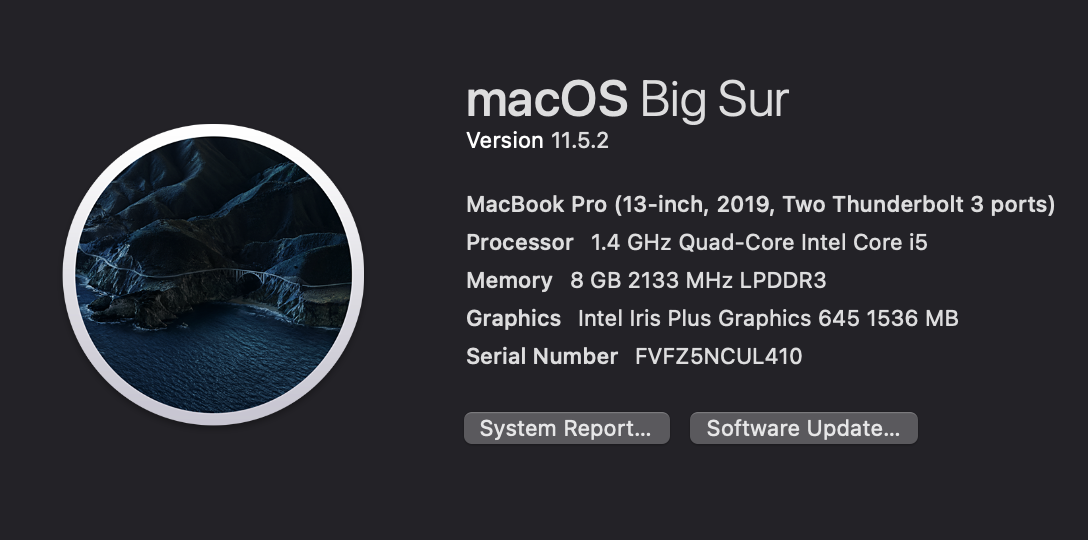

In [ ]:
"""Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

from __future__ import division
from __future__ import print_function

import graph_convolutional_transformer as gct
import tensorflow as tf


def main(argv):
  gct_params = {
      "embedding_size": 128,
      "num_transformer_stack": 3,
      "num_feedforward": 2,
      "num_attention_heads": 1,
      "ffn_dropout": 0.08,
      "attention_normalizer": "softmax",
      "multihead_attention_aggregation": "concat",
      "directed_attention": False,
      "use_inf_mask": True,
      "use_prior": True,
  }

  input_path = argv[1]
  model_dir = argv[2]
  num_iter = 100
  model = gct.EHRTransformer(
      gct_params=gct_params,
      label_key='label.readmission',
      reg_coef=0.1,
      learning_rate=0.00022,
      batch_size=32)
  config = tf.estimator.RunConfig(save_checkpoints_steps=100)

  estimator = tf.estimator.Estimator(
      model_dir=model_dir, model_fn=model.model_fn, config=config)

  train_spec = tf.estimator.TrainSpec(
      input_fn=lambda: model.input_fn(input_path + './train.tfrecord', True),
      max_steps=num_iter)

  eval_spec = tf.estimator.EvalSpec(
      input_fn=lambda: model.input_fn(input_path + './validation.tfrecord', False),
      throttle_secs=1)

  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

  estimator.evaluate(
      input_fn=lambda: model.input_fn(input_path + './validation.tfrecord', False))

if __name__ == '__main__':
  tf.logging.set_verbosity(tf.logging.INFO)
  tf.app.run(main)


## Evaluation

#### Metric Descriptions
The metrics that are produced from training the GCT model are the validation accuracy, test accuracy, validation AUCPR, and test AUCPR.

Accuracy: How often the model predicted the true result

AUCPR: Area Under the Precision-Recall - Precision being the ratio between the true positive predictions and the total number of positive predictions, and Recal being the ratio of true positive predictions with the total number of actual positives.


#### Evaluation Code

The code for our evaluation is luckily the same as our training code, we simply run the code again but with training set to eval mode. In eval mode, the params are no longer changed and the metrics are simply tested / calculated off of the model's accuracy against the data. 

To run the code in evaluation mode we simply switch the mode of model_fn(self, features, labels, mode) in our model to tf.estimator.ModeKeys.eval as the mode and rerun the training code.

# Results
The table below shows the results of our GCT model in two different predictive tasks
**Task**|**Validation AUCPR**|**Test AUCPR**
:-----:|:-----:|:-----:
Graph reconstruction|0.5972 (0.0027)|0.5965 (0.0031)
Diagnosis-Treatment classification|0.8686 (0.0103)|0.8671 (0.0247)

For the graph reconstruction task, the GCT model validation AUCPR was 0.5972 and the test AUCPR was 0.5965.
-	The GCT model can reconstruct the graphical structure of EHRs with moderate performance. The AUPCR values are not incredibly high but the model still has the ability to capture some relationships within EHR data.
For the diagnosis-treatment classification task, the GCT model performed significantly better with a validation AUCPR of 0.8686 and a test AUCPR of 0.8671.
-	The GCT model performs quite well in predicting the relationship between diagnoses and treatments in EHRs. The model learns the patterns and dependencies between different medical events, which enables accurate classification.

In both tasks summarized above, the results line up with the initial paper hypothesis that using GCTs to understand the graph structures in EHR data could improve performance in predictive healthcare tasks. While the AUCPR values were not all incredibly high, they still demonstrate the GCT model’s ability to capture relationships in EHR data. This could ultimately lead to the enhancement of predictive healthcare tasks. 

To further explore the performance of the GCT model, we used Baseline models to compare the performance with various combinations of features. The results are seen below:

**Task**|**eICU Masked Diagnosis Code Prediction**|**eICU Masked Diagnosis Code Prediction**|**Graph reconstruction**|**Graph reconstruction**|**Diagnosis-Treatment classification**|**Diagnosis-Treatment classification**
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
**Model**|**Validation Accuracy**|**Test Accuracy**|**Validation AUCPR**|**Test AUCPR**|**Validation AUCPR**|**Test AUCPR**
GCNP|0.7434 (0.0072)|0.7432 (0.0086)|0.5807 (0.0019) |0.5800 (0.0021) |0.8439 (0.0166) |0.8443 (0.0214)
GCNrandom|0.7129 (0.0044)|0.7186 (0.0067)|0.5644 (0.0018) |0.5635 (0.0021)|0.7839 (0.0144)|0.7804 (0.0214)
Shallow|0.7313 (0.0026)|0.7364 (0.0017)|0.5443 (0.0015)|0.5441 (0.0017)|0.8530 (0.0181)|0.8555 (0.0206)
Deep|0.7309 (0.0050)|0.7344 (0.0043)|-|-|0.8210 (0.0096)|0.8198 (0.0046)
Transformer|0.7190 (0.0040)|0.7170 (0.0061)|0.5755 (0.0020)|0.5752 (0.0015)|0.8329 (0.0282)|0.8380 (0.0178)
GCT|0.7704 (0.0047)|0.7704 (0.0039)|0.5972 (0.0027)|0.5965 (0.0031)|0.8686 (0.0103)|0.8671 (0.0247)

eICU Masked Diagnosis Code Prediction:
-	The GCT model outperforms all other models in validation and test accuracies. This shows that the GCT strong in capturing complex relationships within the data.
Graph Reconstruction:
-	Again, the GCT model outperforms all other models in both validation and test AUCPR scores. This shows that the GCT architecture is strong in reconstructing the graphical structure of EHRs.
Diagnosis-Treatment Classification:
-	Once more, the GCT model outperforms all other models in both validation and test AUCPR scores. This shows that the GCT architecture is strong in classifying the relationships between diagnoses and treatments within EHRs. 

Overall, these results show the effectiveness of the GCTin learning the graphical structure of electronic health records. The GCT model outperforms other models across all demonstrated tasks, which shows its potential in improving predictive healthcare tasks. The results show that using graph-based approaches, especially with transformer architectures, could potentially advance the field of health data science and improve the quality of care that patients are receiving.



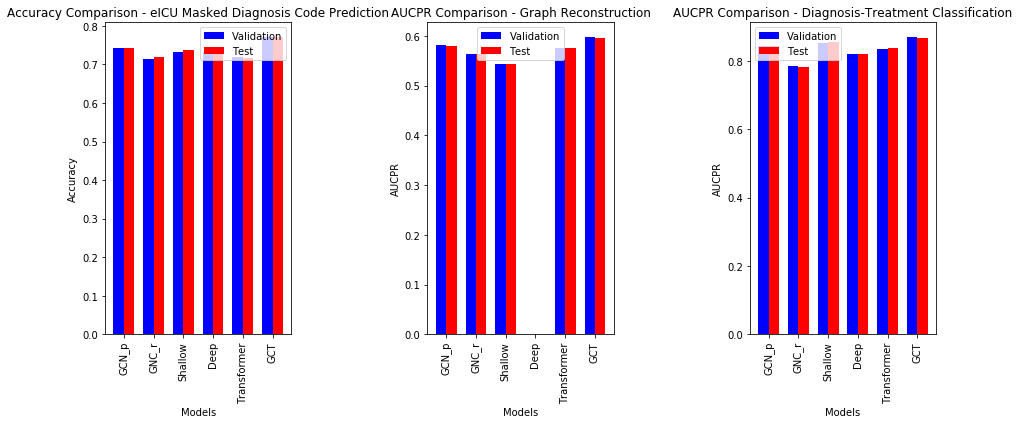

In [5]:
# Plotting eicu
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
bar_width = 0.35
index = np.arange(len(models))
plt.bar(index, eicu_v_acc, bar_width, label='Validation', color='b')
plt.bar(index + bar_width, eicu_t_acc, bar_width, label='Test', color='r')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison - eICU Masked Diagnosis Code Prediction')
plt.xticks(index + bar_width/2, models, rotation='vertical')
plt.legend()

# Plotting graph reconstruction
plt.subplot(1, 3, 2)
bar_width = 0.35
index = np.arange(len(models))
plt.bar(index, GR_v_AUCPR, bar_width, label='Validation', color='b')
plt.bar(index + bar_width, GR_t_AUCPR, bar_width, label='Test', color='r')
plt.xlabel('Models')
plt.ylabel('AUCPR')
plt.title('AUCPR Comparison - Graph Reconstruction')
plt.xticks(index + bar_width/2, models, rotation='vertical')
plt.legend()

# Plotting graph reconstruction 
plt.subplot(1, 3, 3)
bar_width = 0.35
index = np.arange(len(models))
plt.bar(index, DTC_v_AUCPR, bar_width, label='Validation', color='b')
plt.bar(index + bar_width, DTC_t_AUCPR, bar_width, label='Test', color='r')
plt.xlabel('Models')
plt.ylabel('AUCPR')
plt.title('AUCPR Comparison - Diagnosis-Treatment Classification')
plt.xticks(index + bar_width/2, models, rotation='vertical') 
plt.legend()

plt.subplots_adjust(wspace=0.4)  
plt.tight_layout()
plt.show()


# Discussion

### Implications

The results presented in this study reflect those in the original paper. There are definitely significant implications from this paper for healthcare predictive tasks, specifically in learning the graphical structure of EHRs using the GCT architecture. The findings of our study show that there is promise in using graph-based approaches to improve healthcare predictive tasks such as masked diagnosis code prediction, graph reconstruction, and diagnosis-treatment classification. The approach discussed in this paper can likely also be leveraged for other predictive tasks such as treatment recommendation and patient mortality prediction.
 
The performance of the GCT model across various tasks shows its ability to capture relationships that are inherent in EHR data. This shows that GCT models are suited to model the interactions between various medical events and entities which could then lead to improved predictive accuracy. 
 
In terms of reproducibility, the original paper provided detailed descriptions of experimental setup including things like model architectures, hyperparameters, and evaluation metrics. This helped us in reproducing the results to a certain extent. However, there are some factors that made it difficult. 
 
#### What was Easy:
-       The original authors provided code for their models along with the paper which facilitated the replication of their model development.

-       The paper also clearly outlined their experiment methods in great detail, including data preprocessing, model architectures, and evaluation metrics.
 
#### What was Difficult:
-       Data Accessibility: EHR data is sensitive and subject to regulation so there was a lengthy process required before we could even see the data used in the paper.

-       Computing power: Given the size of the data and complexity of the model, computing power was often a limitation for us. Our 1.4 HX Quad Core i5 did not have the capbility we needed, where an i7 or i9 would be preferred for deep learning. Same with our RAM capacity being 8 GB compared to a needed 16 or 32 GB
 
### Recommendations for Improving Reproducibility

Python libraries have greatly improved over the last few years. There are many more efficient capabilities from Python 2 to Python 3, and this code being in Python 2.7 made reproducibility significantly more challenging, as Python 2.7 is not even a supported version anymore. Colab was not an option for us for this reason as well, as much of the code in this is not supported by Colab.

We initially attempted to convert this code to a Python 3.5 update, but there were many outdated parts where this was not possible. Thus we had to configure our system to better fit the needs of the original code, and then make adjustments from there.

We would suggest a secondary pass through by this team, as they clearly know how to create a deep learning model with significant capabilities, but given that code is ever evolving, they should attempt to revamp their methodologies for the greatest success.

# References
